In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# import data
created a function to look at data on your desktop in a folder labeled **data**

In [10]:

def import_raw_data(operating_system ='mac'):
    '''generate a dictionary of raw dataframes
    
    parameters
    -----------
    type of operating system used windows or mac
    default mac
    
    '''
    if operating_system == 'mac':
        base_file_path = r"/Users/{}/Desktop/data".format(os.getlogin())
    if operating_system == 'windows':
        base_file_path = r"C:\Users\{}\Desktop\data".format(os.getlogin())
    df_dict = dict()
    for file in os.listdir(base_file_path):
        if file.endswith('.csv'):
            df_dict[file.split('.')[0]] = pd.read_csv(os.path.join(base_file_path,file))
    return df_dict

In [34]:
df_dict = import_raw_data()
filenames = list(df_dict.keys())
test = df_dict['winemag-data-130k-v2'] 
test2 = df_dict['winemag-data_first150k']

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [35]:
df_dict.keys()

dict_keys(['winemag-data-130k-v2', 'winemag-data_first150k'])

**check out the differences between the two files**

combine together if not hugely different

1.first version wine

In [15]:
wine_version_one = df_dict.get(filenames[1])
wine_version_one.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [27]:
wine_version_one.info()
print("df shape", wine_version_one.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150930 entries, 0 to 150929
Data columns (total 11 columns):
Unnamed: 0     150930 non-null int64
country        150925 non-null object
description    150930 non-null object
designation    105195 non-null object
points         150930 non-null int64
price          137235 non-null float64
province       150925 non-null object
region_1       125870 non-null object
region_2       60953 non-null object
variety        150930 non-null object
winery         150930 non-null object
dtypes: float64(1), int64(2), object(8)
memory usage: 12.7+ MB
df shape (150930, 11)


In [17]:
wine_version_two = df_dict.get(filenames[0])
wine_version_two.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [28]:
wine_version_two.info()
print("df shape", wine_version_two.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
Unnamed: 0               129971 non-null int64
country                  129908 non-null object
description              129971 non-null object
designation              92506 non-null object
points                   129971 non-null int64
price                    120975 non-null float64
province                 129908 non-null object
region_1                 108724 non-null object
region_2                 50511 non-null object
taster_name              103727 non-null object
taster_twitter_handle    98758 non-null object
title                    129971 non-null object
variety                  129970 non-null object
winery                   129971 non-null object
dtypes: float64(1), int64(2), object(11)
memory usage: 13.9+ MB
df shape (129971, 14)


**difference in columns**

In [29]:
print(f"version 1 has {len(wine_version_one.columns)} and version 2 has {len(wine_version_two.columns)}")
column1 = set(list(wine_version_two.columns))
column2 = set(list(wine_version_one.columns))
print(f"{column2-column1} columns missing from version from version 1 data")

version 1 has 11 and version 2 has 14
set() columns missing from version from version 1 data


# General Cleaning

In [40]:
# wine_version_two.drop(inplace=True,columns=['Unnamed: 0'])
# wine_version_two = wine_version_two.reset_index(drop=True)
print(wine_version_two.shape)

(129971, 13)


general stastic for the data

In [37]:
wine_version_two.describe()

,points,price
count,129971.000000,120975.000000
mean,88.447138,35.363389
std,3.039730,41.022218
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


In [44]:
print(f"number of duplicates: {wine_version_two[wine_version_two.duplicated(['points','title','description'])].shape[0]}")

number of duplicates: 9983


In [45]:
data = wine_version_two.drop_duplicates(subset=['points','title','description'])
data = data.reset_index(drop=True)

# Missing values

In [53]:
total = data.isnull().sum()
percent = (data.isnull().sum()/data.isnull().count()*100) 
missing = pd.concat([total,percent],axis=1,keys=['Total','percent']).sort_values(ascending=False,by=['Total','percent'])
missing

,Total,percent
region_2,73219,61.021936
designation,34545,28.790379
taster_twitter_handle,29446,24.540787
taster_name,24917,20.766243
region_1,19560,16.301630
price,8395,6.996533
country,59,0.049172
province,59,0.049172
variety,1,0.000833
description,0,0.000000


price missing 8395 from check relevance

In [54]:
#TODO : check relevance of missing price later

# Histogram of points

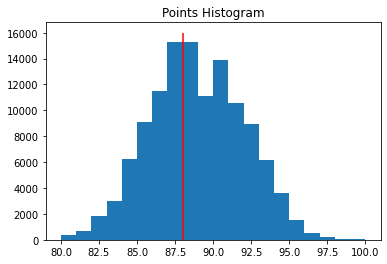

In [67]:
fig = plt.Figure(figsize=(5,8))
ax = fig.add_subplot()
plt.title('Points Histogram')
plt.hist(x=data['points'],bins=20)
plt.vlines(x=data['points'].median(),ymin=0,ymax=16000,color='r')
plt.show()

# countries points by province & country

check relation to points & province & country

In [81]:
PRICE = 'price'
POINTS = 'points'
def generate_groupby_df(df, key, feature):
    return df.groupby([key])[feature].mean().reset_index().sort_values(by=feature,ascending=False)

In [88]:
# country by mean point 
for i,v in zip([PRICE,POINTS,PRICE,POINTS],['country','country','province','province']):
    country_df = generate_groupby_df(data,v,feature=i)
    print("\n",country_df.head(10))
# TODO add quality/price ratio


         country      price
38  Switzerland  72.833333
14      England  52.677966
17      Germany  43.460789
19      Hungary  42.234375
15       France  41.994105
22        Italy  39.928286
40           US  36.697520
7        Canada  35.776786
2     Australia  35.686491
21       Israel  31.770419

        country     points
14     England  91.746032
20       India  90.250000
3      Austria  90.129532
17     Germany  89.895582
7       Canada  89.309735
19     Hungary  89.294574
9        China  89.000000
15      France  88.866752
24  Luxembourg  88.800000
28     Morocco  88.708333

               province       price
82             Colares  262.500000
400         Vânju Mare  166.000000
349        Switzerland  160.000000
202            Madeira  115.181818
231  Moscatel do Douro   94.750000
300        Puente Alto   84.500000
306           Rheingau   83.163763
75           Champagne   80.612928
44                Buin   77.714286
324         Santa Cruz   77.500000

           province     p